### TEAM:
- Anton Rudchenko
- Arnold Luich

Dataset link: https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908

In [1]:
#@title Imports

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import math, datetime, re, operator
from datetime import date, timedelta

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics

In [ ]:
#@title Unused code bank

# Here we need to process a bit our labels to be float, like 0 if nothing happened and 1 if there was smth bad...
# for i in range(0, len(labels)):
#   if isinstance(labels[i], str): labels[i] = 1
#   else: labels[i] = 0

# data["Date"] = pd.to_numeric(pd.to_datetime(data["Date"]))
# data["Time"] = data["Time"].replace('', '00:00')

# Somehow these methods do not work, gonna do individually
# data["Time"] = data["Time"].replace('c:', '')
# data["Time"] = data["Time"].replace('c: ', '')
# data["Time"] = data["Time"].replace('c', '')

# data["Date"] = pd.to_numeric(pd.to_datetime(data["Date"]))
# data["Date"] = pd.to_datetime(data["Date"])

# data["Location"] = data["Location"].replace('Near Sarowbi, Afghanistan', "Afghanistan")
# data["Time"] =  pd.to_timedelta(data["Time"])

# def rep(st):
#   var = st.replace('/', ' ')
#   var = var.split()
#   return var[-1]

# data['Date'] = data['Date'].apply(rep)

# features = pd.get_dummies(inf, columns = ["Location", "Operator", "Route", "Type"])

# from sklearn.preprocessing import OneHotEncoder

# inf["Route"] = inf["Route"].replace("Not known", 0)
# inf["Location"] = OneHotEncoder().fit_transform(inf[["Location"]])

# le = preprocessing.LabelEncoder()
# columns = ["Location", "Operator", "Route", "Type"]
# inf[columns] = inf[columns].apply(le.fit_transform)
# inf["Aboard"] = le.fit_transform(inf["Aboard"])

In [10]:
#@title Data preprocessing

data = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")

data["Time"] = data["Time"].replace('c16:50', '16:50')
data["Time"] = data["Time"].replace('12\'20', '12:20')
data["Time"] = data["Time"].replace('18.40', '18:40')
data["Time"] = data["Time"].replace('114:20', '14:20')
data["Time"] = data["Time"].replace('c14:30', '14:30')
data["Time"] = data["Time"].replace('0943', '09:43')
data["Time"] = data["Time"].replace('22\'08', '22:08')
data["Time"] = data["Time"].replace('17.0', '17:00')
data["Time"] = data["Time"].replace(np.nan, '00:00')

data["Time"] = data["Time"].replace('c: 1:00', '1:00')
data["Time"] = data["Time"].replace('c:17:00', '17:00')
data["Time"] = data["Time"].replace('c: 2:00', '2:00')
data["Time"] = data["Time"].replace('c:09:00', '09:00')
data["Time"] = data["Time"].replace('c: 9:40', '9:40')

data["Date"] = data["Date"].replace('o', '')
data['Time'] = data['Date'] + ' ' + data['Time']

def conversion(str_date):
  dtc = datetime.datetime.strptime(str_date, '%m/%d/%Y %H:%M')
  return dtc

def pr_f(locat):
  try:
    m = locat.split(",")[-1].lstrip()
  except:
    m = locat
  return m

def pr_d(locat):
  try:
    m = locat.split("/")[-1].lstrip()
  except:
    m = locat
  return m

data['Time'] = data['Time'].apply(conversion)

data['Location'] = data['Location'].apply(pr_f)
data['Date'] = data['Date'].apply(pr_d)

data = data.replace(np.nan, "Not known")
data["Fatalities"] = data["Fatalities"].replace('Not known', 0)

del data['Flight #']
del data['cn/In']
del data['Ground']
del data['Registration']

# data.head(10)

data.isnull().sum()

FileNotFoundError: ignored

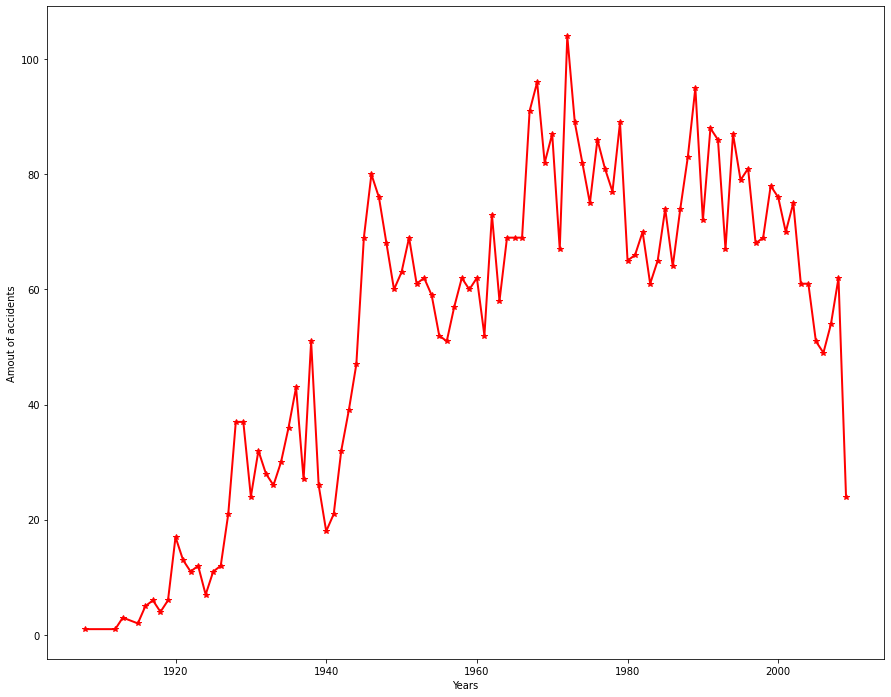

In [4]:
#@title Accidents through years

inf = data.groupby(data.Time.dt.year)[['Date']].count()

plt.figure(figsize=(15,12))
plt.plot(inf.index, 'Date', data=inf, color='red', marker = "*", linewidth=2)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amout of accidents', fontsize=10)

# font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 2}
# plt.rc('font', **font)

plt.show()

# In general, it can be seen that the accidents start to drop after 1980s.

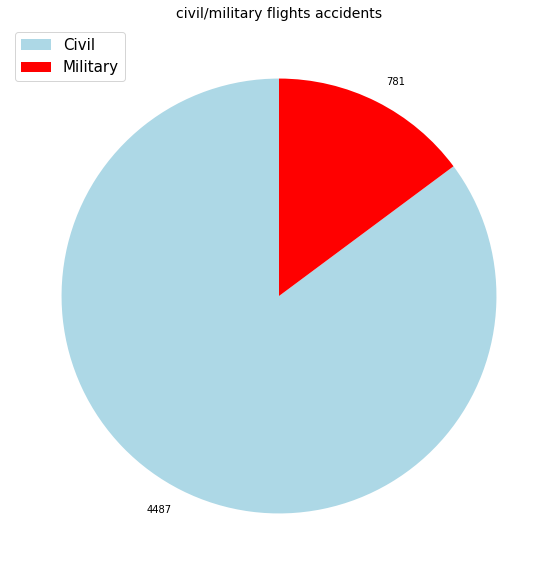

In [5]:
#@title Civil to military comparison

plt_d = data.copy()
plt_dd = data.copy()

plt_d['isMilitary'] = plt_d.Operator.str.contains('Military')
plt_d = plt_d.groupby('isMilitary')[['isMilitary']].count()
plt_d.index = ['Civil', 'Military']


plt_dd['Military'] = plt_dd.Operator.str.contains('Military')
plt_dd['Civil'] = plt_dd.Military == False

plt_dd = plt_dd.loc[:, ['Time', 'Military', 'Civil']]
plt_dd = plt_dd.groupby(plt_dd.Time.dt.year)[['Military', 'Civil']].aggregate(np.count_nonzero)

plt.figure(figsize=(15, 10))


plc, pls = plt.pie(plt_d.isMilitary, labels=plt_d.isMilitary, colors=['lightblue', 'red'], startangle=90)
plt.legend(plc, plt_d.index, loc="best", fontsize=15)
plt.title('civil/military flights accidents', fontsize=14)
plt.show()


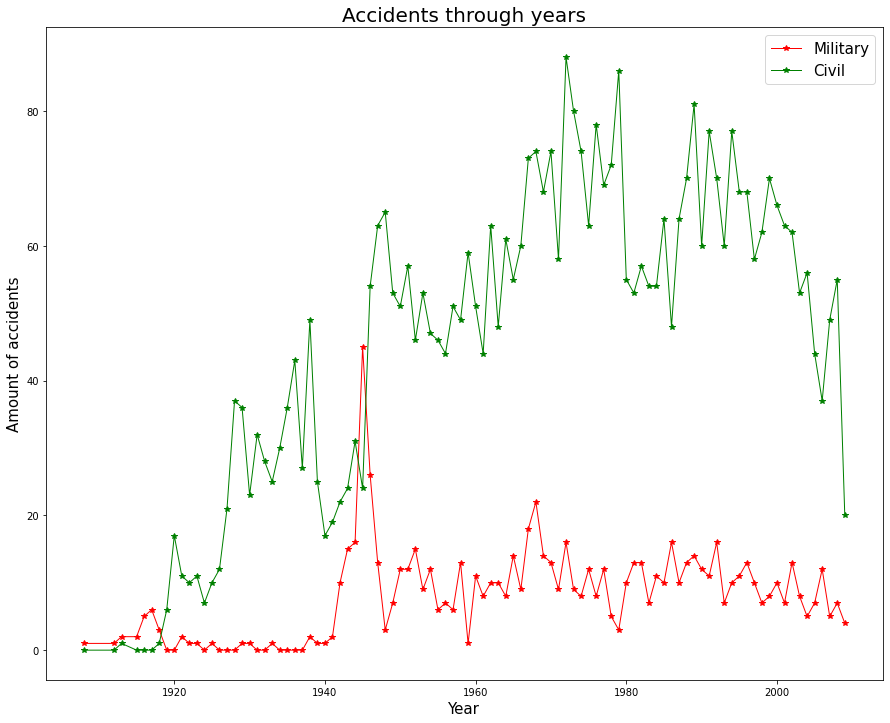

In [6]:
#@title Accidents through years
plt.figure(figsize=(15, 12))

plt.plot(plt_dd.index, 'Military', data=plt_dd, color='red', marker = "*", linewidth=1)
plt.plot(plt_dd.index, 'Civil', data=plt_dd, color='green', marker = "*", linewidth=1)

plt.legend(fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Amount of accidents', fontsize=15)
plt.title('Accidents through years', fontsize=20)
plt.show()

# It can be seen that with years the accidents among civil flight only rise, and starting to drop only after 1980, when military aircrafts accidents starting from 1950 has more or less same pattern.

In [7]:
temp = data.copy()
temp = temp.replace('Not known',np.NaN)
temp['Year'] = temp.Time.dt.year
pd.to_numeric(temp['Year'])
pd.to_numeric(temp['Aboard'])
pd.to_numeric(temp['Fatalities'])
temp = temp.groupby("Year").sum()

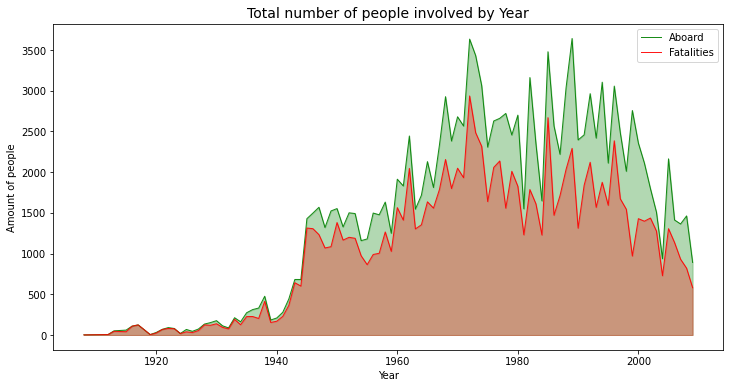

<Figure size 432x288 with 0 Axes>

In [8]:
temp['Proportion'] = temp['Fatalities'] / temp['Aboard']

plt.figure(figsize=(12,6))

plt.fill_between(temp.index, 'Aboard', data=temp, color="green", alpha=0.3)
plt.plot(temp.index, 'Aboard', data=temp, color="green", alpha=0.9, linewidth=1)

plt.fill_between(temp.index, 'Fatalities', data=temp, color="red", alpha=0.3)
plt.plot(temp.index, 'Fatalities', data=temp, color="red", alpha=0.9, linewidth=1)

plt.legend(fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Amount of people', fontsize=10)
plt.title('Total number of people involved by Year', loc='Center', fontsize=14)
plt.show()
plt.savefig('peopleInvolved')

Ratio: Fatalities/Aboard


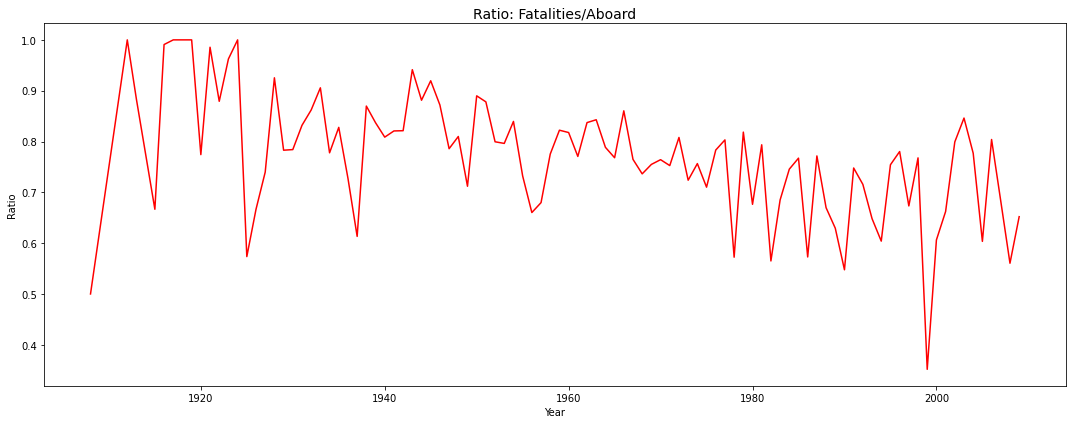

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(15,6))
plt.plot(temp.index, 'Proportion', data=temp, color = 'red', linewidth=1.5)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Ratio', fontsize=10)
plt.title('Ratio: Fatalities/Aboard', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig('fatalities')

# Defining RandomForestClassifier model and training it for futher anaysing

In [ ]:
inf = (data[["Date", "Location", "Operator",  "Route", "Type", "Aboard"]]).copy()

features = pd.get_dummies(inf)#, columns = ["Location", "Operator", "Route", "Type"])

labels = data["Fatalities"].astype('int')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=math.ceil(len(data)*0.2), random_state=5)

model = RandomForestClassifier(n_estimators=500, max_depth=75, min_samples_split=20, min_samples_leaf=1, criterion='entropy', bootstrap=False)
model.fit(X_train, y_train)

acc = accuracy_score(y_test, model.predict(X_test)) * 100
print(round(acc, 2))

62.81


In [ ]:
inf.head(5)

,Date,Location,Operator,Route,Type,Aboard
0,1908,Virginia,Military - U.S. Army,Demonstration,Wright Flyer III,2.0
1,1912,New Jersey,Military - U.S. Navy,Test flight,Dirigible,5.0
2,1913,Canada,Private,Not known,Curtiss seaplane,1.0
3,1913,Over the North Sea,Military - German Navy,Not known,Zeppelin L-1 (airship),20.0
4,1913,Germany,Military - German Navy,Not known,Zeppelin L-2 (airship),30.0


<ipython-input-32-45d925d9736a>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(sum(fts_inf)), X_train.columns[fts_inf])


Text(0, 0.5, 'Feature')

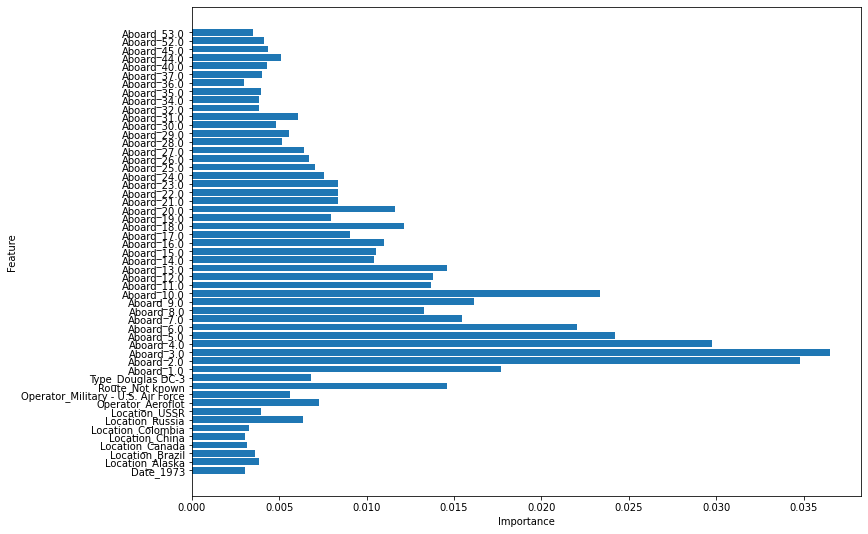

In [ ]:
#@title Analysing which parameters imply the accuracy the most

figsize = plt.subplots(figsize = (12, 9))

fts_inf = model.feature_importances_ > 0.003

plt.barh(range(sum(fts_inf)), model.feature_importances_[fts_inf], align = 'center')
plt.yticks(pd.np.arange(sum(fts_inf)), X_train.columns[fts_inf])
plt.xlabel("Importance")
plt.ylabel("Feature")

# From the graph above it can be seen that the number of people aboard imply the model prediction significantly (had high importance when decision was made), the biggest importance stand for aboard feature to be smaller (1 - 4 people aboard).

In [ ]:
#@title Looking for best parameters

# from sklearn.model_selection import RandomizedSearchCV


# n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# max_features = ['auto', 'sqrt']
# max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# min_samples_leaf = [1, 2, 3, 4]
# bootstrap = [True, False]
# criterion=['gini', 'entropy']

# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
#                'criterion': criterion}

# rf_base = RandomForestClassifier()

# rf_random = RandomizedSearchCV(estimator = rf_base,
#                                param_distributions = random_grid,
#                                n_iter = 30, cv = 5,
#                                verbose=2,
#                                random_state=42, n_jobs = 4)
# rf_random.fit(X_train, y_train)

# print (rf_random.score(X_train, y_train))
# print(rf_random.score(X_test, y_test))

In [ ]:
#@title References

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908
# https://www.kaggle.com/code/ruslankl/airplane-crashes-data-visualization
# https://stackoverflow.com/questions/61162762/how-to-limit-number-of-features-plotted-on-feature-importance-graph-of-decision
